In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from model import get_model
import erum_data_data as edd
from dataset import pdgTokens

# Example using the common interface for the erum-data classifier comparison
See https://github.com/erikbuh/erum_data_data

In [2]:
dataset_args = dict(dataname="belle", cache_dir = './', cache_subdir = 'datasets')
X_train, y_train  = edd.load(dataset='train', **dataset_args)
X_test, y_test  = edd.load(dataset='test', **dataset_args)

In [3]:
edd.print_description("belle")



SmartBKG dataset (Belle II - generated events passing downstream selection)

The goal of this classification problem is to identify generated events that pass a selection already before the expensive detector simulation and reconstruction.

Original dataset and additional information: https://github.com/kahn-jms/belle-selective-mc-dataset

----------------------------------    
Dataset shape:

Two sets of input data: 
- first set with shape:
    - 280000 belle collider events
    - 100 particles (zero padded)
    - 9 features ('prodTime', 'energy', 'x', 'y', 'z', 'px', 'py', 'pz', 'PID')
        - note: PID corresponding to a unique PDG particle ID, but mapped to a continous space
        
- second set with shape:
    - 280000 belle collider events
    - 100 indices of mother particles (adjacency matrix for creating a graph of the event)
        - note: these are -1 padded
---------------------------------- 
Label: 
event passes (1) or fails (0) a selection that was applied after det

Put the particle features, pdg ids and adjacency indices into separate dictionary fields for training.

In [4]:
def input_dict(X):
    return {
        "x_feature" : X[0][:, :, : -1],
        "x_pdg" : X[0][:, :, -1],
        "x_adjacency" : X[1],
    }

In [5]:
X_train_dict, X_test_dict = [input_dict(X) for X in [X_train, X_test]]

# The reference model

The reference model consists of 2 Blocks, 1 Block is a per-particle transformation (including a few simple Graph convolution layers) and then after summing the latent space for all particles a Block of Dense layers that perform an event-level transformation. Have a look at `model.py`

The mother indices are converted to adjacency matrices on-the-fly.

In [6]:
model = get_model(
    num_nodes=X_train_dict["x_adjacency"].shape[1],
    num_features=X_train_dict["x_feature"].shape[2],
    num_pdg=len(pdgTokens),
)

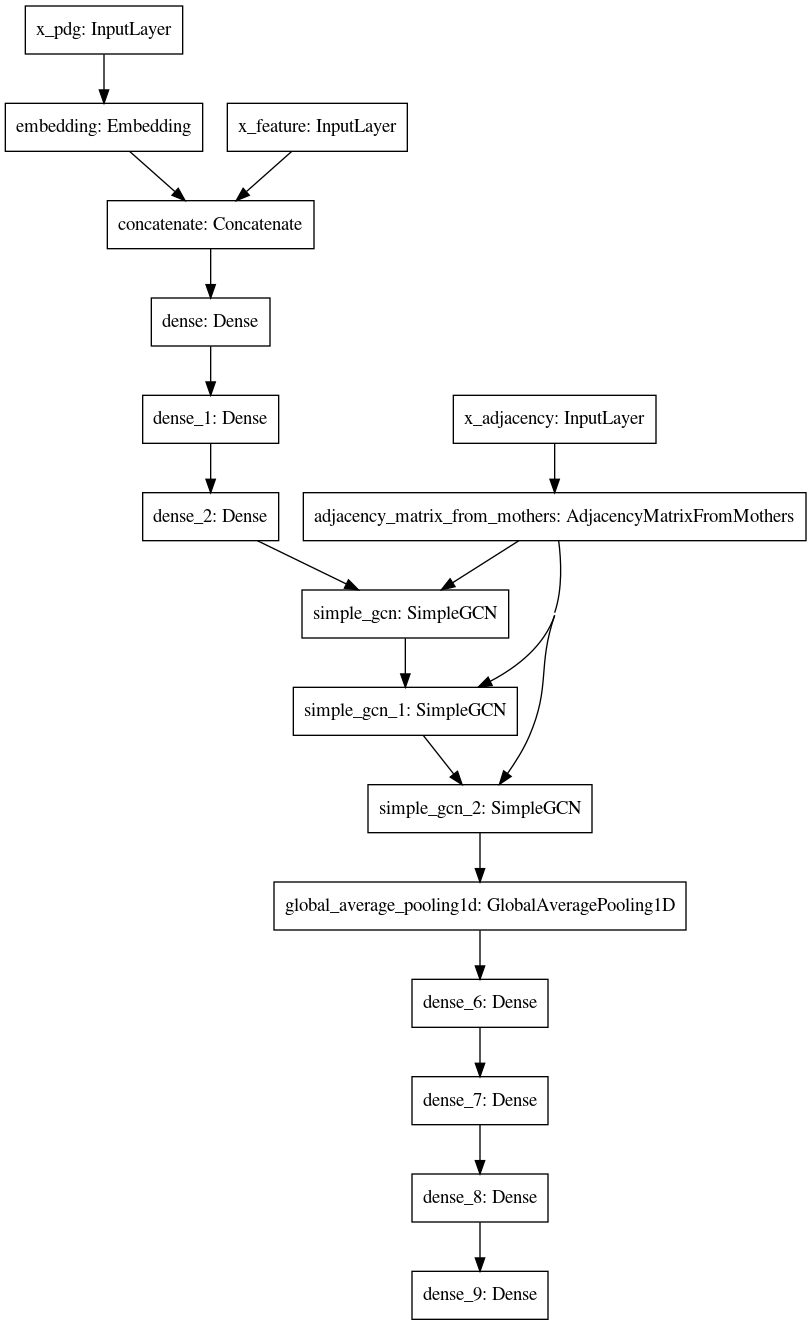

In [7]:
tf.keras.utils.plot_model(model)

In [8]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_pdg (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 8)       4328        x_pdg[0][0]                      
__________________________________________________________________________________________________
x_feature (InputLayer)          [(None, 100, 8)]     0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 100, 16)      0           embedding[0][0]                  
                                                                 x_feature[0][0]       

In [9]:
model.compile(optimizer="adam", loss="binary_crossentropy")

In [10]:
history = model.fit(
    X_train_dict,
    y_train,
    shuffle=True,
    batch_size=128,
    validation_split=0.25,
    epochs=25,
)

Epoch 1/25
1641/1641 [==============================] - 19s 11ms/step - loss: 0.4934 - val_loss: 0.4465
Epoch 2/25
1641/1641 [==============================] - 18s 11ms/step - loss: 0.4450 - val_loss: 0.4282
Epoch 3/25
1641/1641 [==============================] - 18s 11ms/step - loss: 0.4328 - val_loss: 0.4428
Epoch 4/25
1641/1641 [==============================] - 18s 11ms/step - loss: 0.4232 - val_loss: 0.4180
Epoch 5/25
1641/1641 [==============================] - 18s 11ms/step - loss: 0.4160 - val_loss: 0.4108
Epoch 6/25
1641/1641 [==============================] - 18s 11ms/step - loss: 0.4119 - val_loss: 0.4029
Epoch 7/25
1641/1641 [==============================] - 18s 11ms/step - loss: 0.4078 - val_loss: 0.4062
Epoch 8/25
1641/1641 [==============================] - 18s 11ms/step - loss: 0.4048 - val_loss: 0.3985
Epoch 9/25
1641/1641 [==============================] - 18s 11ms/step - loss: 0.4011 - val_loss: 0.4017
Epoch 10/25
1641/1641 [==============================] - 18s 11m

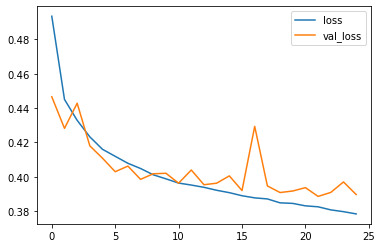

In [11]:
for k in history.history:
    plt.plot(history.history[k], label=k)
plt.legend()

In [12]:
scores = model.predict(X_test_dict, batch_size=1024).ravel()

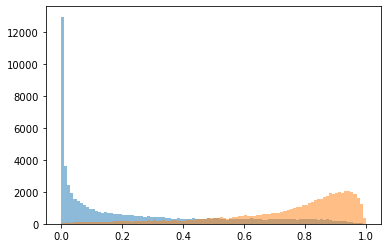

In [13]:
opts = dict(bins=100, range=(0, 1), alpha=0.5)
plt.hist(scores[y_test==0], **opts)
plt.hist(scores[y_test==1], **opts);

In [21]:
from sklearn.metrics import roc_curve, auc

In [22]:
fpr, tpr, thr = roc_curve(y_test, scores)

0.90110059375

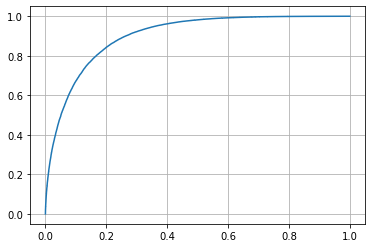

In [23]:
plt.plot(fpr, tpr)
plt.grid()
auc(fpr, tpr)